In [ ]:
from selenium import webdriver
from bs4 import BeautifulSoup
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
import ray
import asyncio
import time

@ray.remote
def page_contents_add(original_url, crawing_url):
    
    driver = webdriver.Chrome('./chromedriver.exe',chrome_options=chrom_options)

    driver.get(crawing_url)
    soup = BeautifulSoup(driver.page_source, 'lxml').body.extract()

    address = []
    for title in soup.select('section#leftColumn div.mediumTitle1 a.title'):
        if 'js-external-link' not in title['class']:
            address.append(original_url + title['href'])

        else:
            if '찾았습니다.' in title.text or '급등주' in title.text or '추천주' in title.text:
                continue
            address.append(title['href'])

    return asyncio.run(main(address, driver))


async def main(address, driver):
    news_content = []
    futures = [asyncio.ensure_future(article_content(url,driver)) for url in address]
    result = await asyncio.gather(*futures)  # 결과를 한꺼번에 가져옴
    driver.close()
    return result


async def article_content(add, driver):
    driver.get(add)
    content = []
    if add.startswith('https://invst.ly'):
        if 'asiae' in driver.current_url:
            try:
                element = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CLASS_NAME, 'article.fb-quotable')))
            except TimeoutError:
                return ''

            text_line = driver.find_element_by_class_name('article.fb-quotable').find_elements_by_tag_name('p')
        elif 'donga' in driver.current_url:
            try:
                element = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CLASS_NAME, 'article_txt')))
            except TimeoutError:
                return ''
            text_line = driver.find_elements_by_class_name('article_txt')
        elif 'news.joins' in driver.current_url:
            try:
                element = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.ID, 'article_body')))
            except TimeoutError:
                return ''
            text_line = driver.find_elements_by_id('article_body')
        elif 'mk' in driver.current_url:
            try:
                element = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CLASS_NAME, 'art_txt')))
            except TimeoutError:
                return ''
            text_line = driver.find_elements_by_class_name('art_txt')
        elif 'fnnews' in driver.current_url:
            try:
                element = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CLASS_NAME, 'cont_art')))
            except TimeoutError:
                return ''
            text_line = driver.find_elements_by_class_name('cont_art')
        else:
            return ''
        #stop_list=['배포금지','Sponsored','무단전재','기자페이지','\n','',' ','|']
        for i in text_line:
            content.append(i.text)


        content = ' '.join(content)

    elif add.startswith('https://kr.investing.com'):
        for i in driver.find_element_by_class_name('WYSIWYG.articlePage').find_elements_by_tag_name('p'):
            content.append(i.text)
        content = ' '.join(content)
    print(content)
    return content


chrom_options = webdriver.ChromeOptions()
chrom_options.add_argument('headless')
chrom_options.add_argument('--disable-gpu')
chrom_options.add_argument('lang=ko_KR')
chrom_options.add_experimental_option("prefs", {
    "profile.default_content_setting_values.notifications": 1
})

ray.init(log_to_driver=False,ignore_reinit_error=True,)
original_url = r'https://kr.investing.com/'
driver = webdriver.Chrome('./chromedriver.exe', chrome_options=chrom_options)

driver.get(original_url)
driver.find_element_by_class_name('searchText.arial_12.lightgrayFont.js-main-search-bar').send_keys('삼성전자\n')
driver.find_element_by_class_name('js-inner-all-results-quote-item.row').click()
news_page_url=[page_contents_add.remote(original_url,driver.current_url+f'-news/{i}') for i in range(1,6,1)]
driver.close()


chk=1
while chk:
    try:
        all_content=ray.get(news_page_url)
        chk=0
    except:
        chk=1


print('완료' if chk == 0 else '재실행')


ray.shutdown()
print(all_content[0])

2021-06-06 00:37:22,432	INFO services.py:1269 -- View the Ray dashboard at http://127.0.0.1:8265
C:\Users\tjqn1\anaconda3\envs\PyPy\lib\site-packages\ipykernel_launcher.py:101: DeprecationWarning: use options instead of chrome_options


In [2]:
import pandas as pd
pd.read_csv('./article.csv',index_col='id')


,articlePage
id,
0,사진제공=삼성전자 [아시아경제 김흥순 기자] 삼성전자\n는 5일 세계 환경의 날을 ...
1,지난 2일 청와대에서 열린 4대그룹 대표 초청 간담회에서 문재인 대통령이 김기남 삼...
2,[이미지출처=연합뉴스] [아시아경제 정현진 기자] 삼성전자가 빠르게 커가는 기업 서...
3,"안녕하세요~ 오늘도 건강한 주식 맛집, 앤츠랩 입니다! :) \n \n지난달 21일..."
4,주말용 콘텐츠 '머니콕'은 매주 엄선한 투자 전문가와의 심층 인터뷰를 통해 믿을 만...
...,...
45,글로벌 반도체 수급난이 2023년까지 이어져 파운드리(위탁생산) 기업의 실적이 꾸준...
46,삼성전기가 와이파이(WiFi) 모듈 사업부 매각을 위해 지난 1월 시행한 입찰에는 ...
47,[이코노믹리뷰=정다희 기자] 코스피가 강보합으로 장을 마쳤다. 기관의 매도세가 지속...


In [5]:
import pandas as pd
import re
from konlpy.tag import Okt
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

news=pd.read_csv('./article.csv',index_col='id')
news=news.dropna()
news=news.drop_duplicates()
news.articlePage=news.apply(lambda x:re.sub("[^가-힣 ]", ' ', x.articlePage),axis=1)
news=news.reset_index(drop=True)
okt = Okt()

noun_buffer = []
for i in news.articlePage:
    tokens = okt.nouns(i)
    noun_buffer.append([token for token in tokens if len(token)>1])
    
news

,articlePage
0,사진제공 삼성전자 아시아경제 김흥순 기자 삼성전자 는 일 세계 환경의 날을 맞...
1,지난 일 청와대에서 열린 대그룹 대표 초청 간담회에서 문재인 대통령이 김기남 삼...
2,이미지출처 연합뉴스 아시아경제 정현진 기자 삼성전자가 빠르게 커가는 기업 서...
3,안녕하세요 오늘도 건강한 주식 맛집 앤츠랩 입니다 지난달 일 현...
4,주말용 콘텐츠 머니콕 은 매주 엄선한 투자 전문가와의 심층 인터뷰를 통해 믿을 만...
...,...
90,글로벌 반도체 수급난이 년까지 이어져 파운드리 위탁생산 기업의 실적이 꾸준...
91,삼성전기가 와이파이 모듈 사업부 매각을 위해 지난 월 시행한 입찰에는 ...
92,이코노믹리뷰 정다희 기자 코스피가 강보합으로 장을 마쳤다 기관의 매도세가 지속...
93,삼성전자가 시가총액 기준으로 전 세계 상장 기업 중 위 반도체 기업 중에서는 ...


<AxesSubplot:>

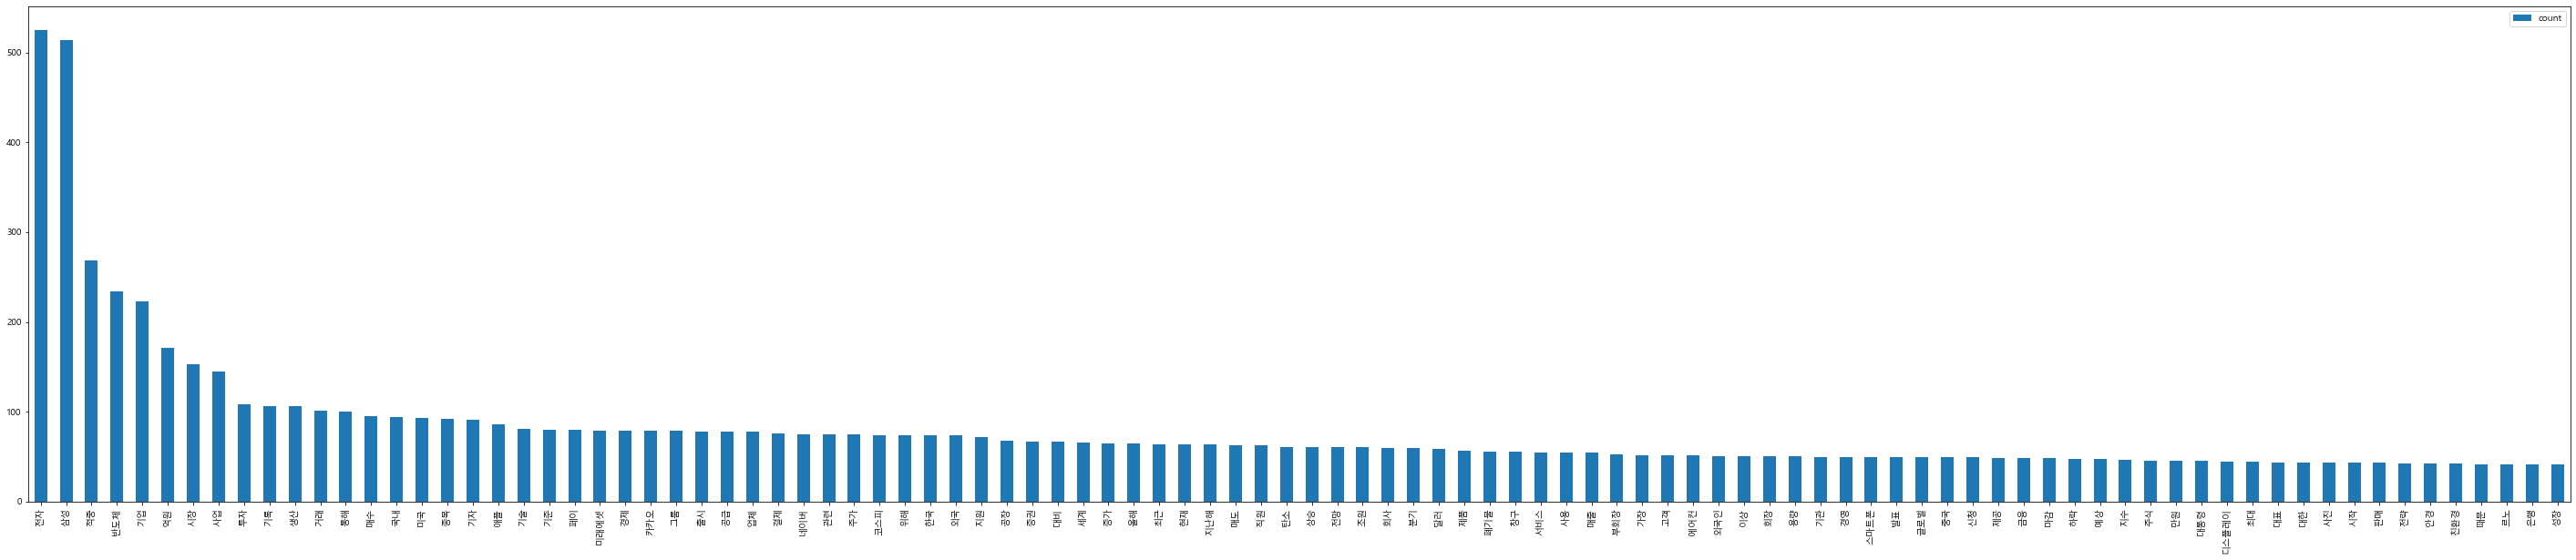

In [6]:
news_noun=pd.DataFrame(data=noun_buffer)
news_noun=news_noun.stack()
news_noun=pd.DataFrame(news_noun,columns=['word'])
news_noun.index.names=['id','pass']

news_cnt=pd.DataFrame(Counter(news_noun.word),index=['count']).T
news_cnt=news_cnt.sort_values(by='count',ascending=False)
news_cnt.head(100).plot.bar(figsize=(50,10))

In [7]:
stop_words=['적중','통해','종목','미래에셋','위해','기자']
news_noun=news_noun[~news_noun.word.isin(stop_words)]
news_noun

word
id pass     
0  0      사진
   1      제공
   2      삼성
   3      전자
   4     아시아
...      ...
94 245    외인
   246    기관
   247    상승
   248    마감
   249    바짝

[25097 rows x 1 columns]

In [8]:
b=news_noun.unstack().to_numpy()
tokenized_doc=[]
for i,j in enumerate(b):
    tokenized_doc.append(' '.join([idx for idx in j if isinstance(idx,str)]))

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
vector = CountVectorizer()
data_vectorized=vector.fit_transform(tokenized_doc)
columns=vector.get_feature_names()

X=pd.DataFrame(data_vectorized.toarray(),columns=columns) # 코퍼스로부터 각 단어의 빈도 수를 기록한다.
X

,가가,가감,가격,가공,가구,가까스로,가까이,가늠,가능,가능성,...,흡수,흡입,흥국,흥행,희귀,희망,희생,희소식,히든,힌트
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,3,...,0,0,0,0,0,1,0,0,0,1
2,0,0,5,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,2,0,0,0,0,0,0,3,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
90,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
91,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
92,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [442]:
lda_model.components_.argsort().shape

(10, 3738)

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation
# Define Search Param
search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(X)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [10, 15, 20, 25, 30]})

In [15]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 10}
Best Log Likelihood Score:  -54757.295308504756
Model Perplexity:  1171.7838880487607


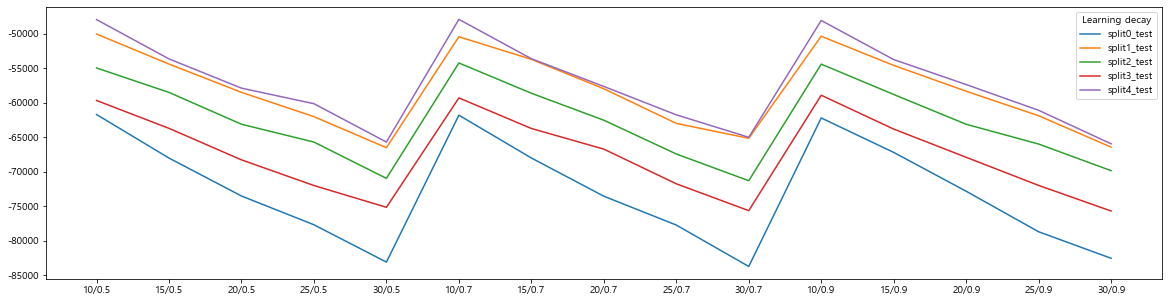

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
plt.plot(model.cv_results_['split0_test_score'],label='split0_test')
plt.plot(model.cv_results_['split1_test_score'],label='split1_test')
plt.plot(model.cv_results_['split2_test_score'],label='split2_test')
plt.plot(model.cv_results_['split3_test_score'],label='split3_test')
plt.plot(model.cv_results_['split4_test_score'],label='split4_test')
plt.xticks(range(15),[str(component)+'/'+str(learning_decay) for component, learning_decay in zip(model.cv_results_['param_n_components'],model.cv_results_['param_learning_decay'])])
plt.legend(title='Learning decay', loc='best')


In [21]:
terms = columns

def get_topics(components, feature_names, n=5):
    for idx, topic in enumerate(components):
        print("Topic %d:" % (idx+1), [(feature_names[i], topic[i].round(2)) for i in topic.argsort()[:-n - 1:-1]])
get_topics(best_lda_model.components_,terms)

Topic 1: [('억원', 100.63), ('기록', 100.53), ('거래', 83.32), ('매수', 77.26), ('외국', 73.1)]
Topic 2: [('반도체', 51.23), ('달러', 39.03), ('전자', 36.86), ('미국', 36.29), ('기업', 31.37)]
Topic 3: [('전자', 53.42), ('에어컨', 51.1), ('삼성', 28.9), ('지난해', 15.54), ('생산', 15.31)]
Topic 4: [('전자', 111.22), ('반도체', 72.78), ('사업', 68.67), ('삼성', 65.87), ('탄소', 55.54)]
Topic 5: [('결제', 72.08), ('페이', 67.1), ('삼성', 55.22), ('전자', 42.68), ('간편', 38.1)]
Topic 6: [('안경', 42.1), ('대통령', 34.1), ('부회장', 30.08), ('그룹', 29.26), ('회장', 28.09)]
Topic 7: [('삼성', 89.63), ('전자', 59.41), ('기업', 56.39), ('반도체', 38.79), ('지원', 37.96)]
Topic 8: [('삼성', 50.78), ('애플', 48.08), ('르노', 39.1), ('기업', 38.86), ('트림', 27.1)]
Topic 9: [('전자', 137.32), ('삼성', 116.38), ('네이버', 58.71), ('카카오', 47.9), ('주가', 39.13)]
Topic 10: [('은행', 26.1), ('임금', 21.1), ('노조', 16.1), ('직원', 13.09), ('피크', 12.1)]


In [22]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(X))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)
# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc0,0.000000,0.000000,0.000000,0.110000,0.880000,0.000000,0.000000,0.000000,0.000000,0.000000,4
Doc1,0.000000,0.290000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.710000,0.000000,8
Doc2,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3
Doc3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,6
Doc4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,6
Doc5,0.030000,0.000000,0.000000,0.160000,0.000000,0.000000,0.000000,0.000000,0.800000,0.000000,8
Doc6,0.000000,0.000000,0.000000,0.000000,0.990000,0.000000,0.000000,0.000000,0.000000,0.000000,4
Doc7,0.000000,0.000000,0.060000,0.000000,0.000000,0.000000,0.000000,0.000000,0.940000,0.000000,8
Doc8,0.000000,0.000000,0.000000,0.000000,0.990000,0.000000,0.000000,0.000000,0.000000,0.000000,4
Doc9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,9


In [23]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vector, mds='tsne')
panel

C:\Users\tjqn1\anaconda3\envs\PyPy\lib\site-packages\sklearn\manifold\_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning


PreparedData(topic_coordinates=                   x              y  topics  cluster          Freq
topic                                                             
8      32.4209518433   8.1152296066       1        1 21.4443372038
3       0.6489552259  71.7070999146       2        1 13.8313953142
0      71.0196838379   9.9710063934       3        1 11.6358923476
6       3.7859814167  33.1851348877       4        1 11.5893884186
4     -42.6665000916  -9.2220697403       5        1 11.1202295823
1      -3.6216893196 -43.5265159607       6        1  8.1827554924
7      -3.6324017048  -4.1717076302       7        1  7.2426377266
2     -36.5844001770  35.8044128418       8        1  6.2056318279
5      44.3913803101  50.6153831482       9        1  5.8627422969
9      40.2358093262 -31.5916652679      10        1  2.8849897898, topic_info=     Term           Freq          Total Category       logprob       loglift
429    기록  96.0000000000  96.0000000000  Default 30.0000000000 30.0000000000
2000   억원 153.0000000000 153.0000000000  Default 29.0000000000 29.0000000000
2189   외국  67.0000000000  67.0000000000  Default 28.0000000000 28.0000000000
120    거래  91.0000000000  91.0000000000  Default 27.0000000000 27.0000000000
957    매수  86.0000000000  86.0000000000  Default 26.0000000000 26.0000000000
...   ...            ...            ...      ...           ...           ...
610    다른   2.6991778733  16.3744605837  Topic10 -5.5919000000  1.7429000000
2678   전자   4.2823602447 465.0866396505  Topic10 -5.1304000000 -1.1421000000
2639   적용   2.6991766560  34.8630607473  Topic10 -5.5919000000  0.9872000000
830    때문   2.6991758322  35.6972153377  Topic10 -5.5919000000  0.9635000000
1855   실적   2.6991714382  29.1647907940  Topic10 -5.5919000000  1.1656000000

[634 rows x 6 columns], token_table=      Topic         Freq   Term
term                           
2         1 0.0563946721     가격
2         2 0.4229600408     가격
2         4 0.1691840163     가격
2         6 0.1127893442     가격
2         7 0.1127893442     가격
...     ...          ...    ...
3729      2 0.8276581510     효율
3729      5 0.0919620168     효율
3740      1 0.9656980330  휘닉스소재
3742      8 0.7497875175     휘센
3748      2 0.8300476519     휴직

[1327 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 4, 1, 7, 5, 2, 8, 3, 6, 10])